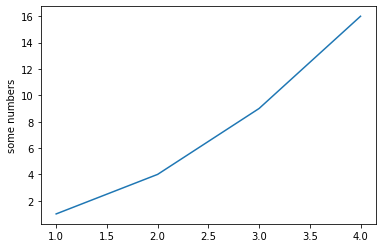

   ROWID  BOROUGH   NEIGHBORHOOD                      BUILDING CLASS CATEGORY  \
0      4        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                
1      5        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                
2      6        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                
3      7        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                
4      8        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                

  TAX CLASS AT PRESENT  BLOCK  LOT EASE-MENT BUILDING CLASS AT PRESENT  \
0                   2A    392    6                                  C2   
1                    2    399   26                                  C7   
2                    2    399   39                                  C7   
3                   2B    402   21                                  C4   
4                   2A    404   55                                  C2   

                  ADDRESS  ... RESIDENTIAL UNITS  COMMERCIAL UNITS  

In [82]:
import numpy as np
import pandas as pd
import csv
import random
import uuid

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from deep_forest import MGCForest

from sklearn.model_selection import train_test_split
#X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
#C, S = np.cos(X), np.sin(X)

import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])
plt.ylabel('some numbers')
plt.show()

df = pd.read_csv("nyc-rolling-sales.csv")
#df = df[df["SALE PRICE"] != ' -  ']
X = df.iloc[:, 0:4].values
y = df.iloc[:, 4].values
location = df["ZIP CODE"]
prices = df["SALE PRICE"]


#Split to training and test set:
X_train, X_test, y_train, y_test = train_test_split(
    location,
    prices,
    test_size=0.2,
    random_state=42,
)

#X_train = X_train.values.reshape((len(X_train), 28, 28)) #67638 
#X_test = X_test.values.reshape((len(X_test), 28, 28))

print('X_train:', X_train.shape, X_train.dtype)
print('y_train:', y_train.shape, y_train.dtype)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)


print(df.head())

In [183]:

df = pd.read_csv("nyc-rolling-sales.csv")

#filter out rows
df = df[df["SALE PRICE"] != ' -  ']
df = df[df["YEAR BUILT"] != 0]
#filter in columns
df = df[['ZIP CODE','YEAR BUILT','SALE PRICE']]
df.head()

X = df.iloc[:, :2].values
y = df.iloc[:, 2].values

#
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature Scaling
#from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print(y_pred)

#evaluate
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



[ 656101.32939161 3852655.34152778  753255.90830364 ...  289019.2867192
  489929.19264069 1333483.37921548]
Mean Absolute Error: 1246750.7292177605
Mean Squared Error: 519455264999980.25
Root Mean Squared Error: 22791561.267275665


In [169]:
max(y_pred)

14214841.830444008

In [171]:
max(regressor.predict(X_grid))

14214841.830444008

In [176]:
type(X_train[0])
X_train[0]

array([1920], dtype=int64)

In [191]:

#predict new result
sample = np.array([10309, 1904]).reshape(1, -1)
y_pred = regressor.predict(sample)
print(y_pred)

[411575.]


ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 1 

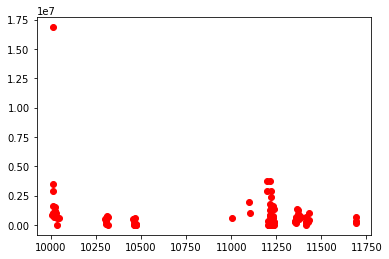

In [184]:

# visualize location

X_grid = np.arange(1900, 2020, 1)
X_grid = X_grid.reshape((len(X_grid), 1))
num_scatter = 100
plt.scatter([int(arr[0]) for arr in X_test[:num_scatter]], [float(num) for num in y_test[:num_scatter]], color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Check It (Random Forest Regression Model)w/100 trees')
plt.xlabel('Year Built')
plt.ylabel('Price')
plt.show()


In [3]:
#NYC zip code map
import sys
import matplotlib.pyplot as plt
from osgeo import ogr

plt.style.use('ggplot') # ggplot formatting

def basemapper(): #geographic plotting routine
    fig,ax = plt.subplots(figsize=(14,10))
    m = Basemap(llcrnrlon=bbox[0],llcrnrlat=bbox[1],urcrnrlon=bbox[2],
               urcrnrlat=bbox[3],resolution='h', projection='cyl') # cylindrical projection ('merc' also works here)
    shpe = m.readshapefile(shapefile.replace('.shp',''),'curr_shapefile')
    m.drawmapboundary(fill_color='#bdd5d5') # map color
    m.fillcontinents(color=plt.cm.tab20c(19)) # continent color
    m.drawcounties(color='k',zorder=999)
    parallels = np.linspace(bbox[1],bbox[3],5) # latitudes
    m.drawparallels(parallels,labels=[True,False,False,False],fontsize=12,linewidth=0.25)
    meridians = np.linspace(bbox[0],bbox[2],5) # longitudes
    m.drawmeridians(meridians,labels=[False,False,False,True],fontsize=12,linewidth=0.25)
    return fig,ax,m


shapefile_folder = './NYC_ZIP_CODE_040114/' # location of city shapefile (locally)
shapefile = shapefile_folder+os.listdir(shapefile_folder)[0].split('_correct_CRS')[0]+'_correct_CRS.shp'
drv    = ogr.GetDriverByName('ESRI Shapefile') # define shapefile driver
ds_in  = drv.Open(shapefile,0) # open shapefile
lyr_in = ds_in.GetLayer() # grab layer
shp = lyr_in.GetExtent() # shapefile boundary
zoom = 0.01 # zooming out or in of the shapefile bounds
bbox = [shp[0]-zoom,shp[2]-zoom,shp[1]+zoom,shp[3]+zoom] # bounding box for plotting
fig,ax,m = basemapper() #handler for plotting geographic data

ModuleNotFoundError: No module named 'osgeo'